# Differential Expression (DE) Analysis

This tutorial demonstrates how to perform differential expression analysis using the `msmu` package. Details about DE analysis methods can be found in the [Differential Expression (DE) Analysis](../../how-it-works/dea) section.

## Load Required Packages

In [28]:
import msmu as mm
import pandas as pd

import plotly.io as pio
pio.renderers.default = "png"

## Data Preparation

Use the `MuData` object as `mdata` processed in tutorials [DDA-TMT](../dda-tmt), [DDA-LFQ](../dda-lfq), or [DIA-LFQ](../dia-lfq). It should have a modality to test, in this case, `protein`.

In this tutorial, we will use the `mdata` processed in [DDA-LFQ](../dda-lfq) tutorial.

In [29]:
base_dir = "https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/main/data/sage_lfq"
sage_idents = f"{base_dir}/sage/results.sage.tsv"
sage_quants = f"{base_dir}/sage/lfq.tsv"
meta = f"{base_dir}/meta.csv"

mdata = mm.read_sage(identification_file=sage_idents, quantification_file=sage_quants, label="label_free")

meta_df = pd.read_csv("https://raw.githubusercontent.com/bertis-informatics/msmu/refs/heads/main/data/sage_lfq/meta.csv")
meta_df = meta_df.set_index("sample_id")  # set the index to match sample id in mdata.obs

mdata.obs = mdata.obs.join(meta_df)
mdata.push_obs()  # update all modalities with the new obs data

mdata = mm.pp.add_filter(mdata, modality="psm", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.add_filter(mdata, modality="psm", column="proteins", keep="not_contains", value="contam_")
mdata = mm.pp.apply_filter(mdata, modality="psm")

mdata = mm.pp.to_peptide(mdata)
mdata = mm.pp.add_filter(mdata, modality="peptide", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="peptide")

mdata = mm.pp.log2_transform(mdata, modality="peptide")
mdata = mm.pp.normalise(mdata, modality="peptide", method="median")

mdata = mm.pp.infer_protein(mdata)

mdata = mm.pp.to_protein(mdata, top_n=3, rank_method="median_intensity")
mdata = mm.pp.add_filter(mdata, modality="protein", column="q_value", keep="lt", value=0.01)
mdata = mm.pp.apply_filter(mdata, modality="protein")

mdata


INFO - Identification file loaded: (5000, 40)
INFO - Quantification file loaded: (3578, 12)
INFO - Decoy entries separated: (345, 15)
INFO - Peptide-level identifications: 3634 (3615 at 1% FDR)
INFO - Starting protein inference
INFO - Initial proteins: 3651


Using existing peptide quantification data.


INFO - Removed indistinguishable: 1586
INFO - Removed subsettable: 539
INFO - Removed subsumable: 2
INFO - Total protein groups: 1524
INFO - Ranking features by 'median_intensity' to select top 3 features.
INFO - Protein-level identifications :  1489 (1463 at 1% FDR)


MuData object with n_obs × n_vars = 6 × 9337
  obs:	'set', 'sample_name', 'condition', 'replicate'
  uns:	'_cmd'
  3 modalities
    psm:	6 x 4259
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'proteins', 'peptide', 'stripped_peptide', 'filename', 'scan_num', 'charge', 'peptide_length', 'missed_cleavages', 'semi_enzymatic', 'contaminant', 'PEP', 'q_value', 'rt', 'calcmass'
      uns:	'level', 'search_engine', 'quantification', 'label', 'acquisition', 'identification_file', 'quantification_file', 'decoy', 'filter', 'decoy_filter'
      varm:	'search_result', 'filter'
    peptide:	6 x 3615
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'peptide', 'proteins', 'stripped_peptide', 'count_psm', 'PEP', 'q_value', 'protein_group', 'peptide_type'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'
    protein:	6 x 1463
      obs:	'set', 'sample_name', 'condition', 'replicate'
      var:	'count_psm', 'count_stripped_peptide', 'PEP', 'q_value'
      uns:	'level', 'decoy', 'filter', 'decoy_filter'
      varm:	'filter'

### (Optional) Load MuData from local file

If `MuData` were saved locally, provide the path to the file in `mm.read_h5mu()` function.

In [27]:
# mdata = mm.read_h5mu("dda_lfq_PXD012986.h5mu")

# mdata

## Run DE analysis

Permutation-based DE analysis basically provided by `mm.tl.run_de()` function. Here, we will compare two conditions, `G1` and `G2`, in the `condition` column of `mdata.obs`.

`modality` specifies which modality to perform DE analysis on. `category` indicates the column name in `mdata.obs` that contains the group labels.

`ctrl` and `expr` define the control and experimental groups, respectively.

`stat_method` allows you to choose the statistical test method, such as `welch`, `student`, or `wilcoxon`.

`measure` defines the measure of central tendency used for calculating fold-change, either `median` or `mean`.

`min_pct` sets the minimum fraction of non-missing values required in at least one group for a feature to be considered in the analysis.

`n_resamples` sets the number of resampling iterations for permutation testing; if set to `None`, simple parametric p-values are computed.

`fdr` specifies the multiple testing correction method, which can be `empirical`, `bh` (Benjamini-Hochberg), or `None`.

`log_transformed` indicates whether the data is log-transformed.


More explanation for `run_de()` can be found in the [DE Analysis](../../how-it-works/dea/) documentation and the [`mm.tl.run_de()`](../../reference/tl/run_de/) API reference.

In an example below, we assign 1000 resamples, but only 20 permutations are performed because each group has 3 samples and 3 by 3 gives 20 combinations, which is `exact` test.


In [30]:
de_res = mm.tl.run_de(
    mdata,
    modality="protein",
    category="condition",  # category in .obs to define groups
    ctrl="G1",             # control group
    expr="G2",             # experimental group
    stat_method="welch",   # statistical test method: "welch", "student", "wilcoxon", default "welch"
    measure="median",      # measure of central tendancy for calculating fold-change: "median", "mean", default "median"
    min_pct=0.5,           # minimum fraction of non-missing values in at least one group, default 0.5
    fdr="empirical",       # multiple testing correction method: "empirical", "bh", or None, default "empirical"
    n_resamples=1000,      # by default, 1000 resamples; if None, simple parametric p-values are computed
    log_transformed=True,  # whether data is log-transformed, default True
)

Running Permutations: 100%|██████████| 20/20 [00:00<00:00, 549.98it/s]


## Explore DE results

Result is stored in `DeaResult` object. And the object provides few methods to explore the results. This object provides `to_df()` method to convert the results into a pandas DataFrame for further exploration. And `plot_volcano()` method to visualize the results as a volcano plot.


In [31]:
de_res

DeaResult(stat_method='welch', ctrl='G1', expr='G2', features=array(['A0A023T778,G3UZW7,P61327,Q9CQL1',
       'A0A068CB13,A2QBC3,B2CNX8,B2CNX9,G3XSF9,I6VCW8,P13006',
       'A0A087WNT1,A0A087WPE4,A0A087WQE6,P83940', ..., 'Q9Z2U0', 'Q9Z2X1',
       'Q9Z315'], shape=(1463,), dtype=object), repr_ctrl=array([23.032452, 25.08355 , 25.420649, ..., 26.587545, 25.655592,
       22.321047], shape=(1463,), dtype=float32), repr_expr=array([23.090721, 28.73562 , 25.331665, ..., 26.365978, 25.997116,
       22.347776], shape=(1463,), dtype=float32), pct_ctrl=array([100., 100., 100., ..., 100., 100., 100.], shape=(1463,)), pct_expr=array([100., 100., 100., ..., 100., 100., 100.], shape=(1463,)), log2fc=array([ 0.0582695 ,  3.652071  , -0.08898354, ..., -0.22156715,
        0.34152412,  0.02672958], shape=(1463,), dtype=float32))

In [32]:
de_res.to_df().head()

,features,repr_ctrl,repr_expr,pct_ctrl,pct_expr,log2fc,p_value,q_value
0,"A0A023T778,G3UZW7,P61327,Q9CQL1",23.032452,23.090721,100.0,100.0,0.058270,0.443105,0.813088
1,"A0A068CB13,A2QBC3,B2CNX8,B2CNX9,G3XSF9,I6VCW8,...",25.083549,28.735620,100.0,100.0,3.652071,0.000174,0.075433
2,"A0A087WNT1,A0A087WPE4,A0A087WQE6,P83940",25.420649,25.331665,100.0,100.0,-0.088984,0.970467,0.904035
3,"A0A087WNT3,A0A087WNU9,A0A087WP64,A0A087WPE6,A0...",NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,"A0A087WNY6,A0A087WQA5,A0A087WQX8,A0A087WRP4,A0...",25.827114,25.794582,100.0,100.0,-0.032532,0.821479,0.880609


After permutation test, guidance for log2FC threshold at 5% (or 1%) on two-sided tails of null distribution from permutations is also provided.


In [33]:
print(f"Log2FC threshold at 5%: {de_res.fc_pct_5}")

Log2FC threshold at 5%: 0.33


To visualize the DE results, `plot_volcano()` method is available. Log2FC and p-value thresholds can be set manually or automatically using the `fc_pct_5` attribute from the result object and p-value of `0.05`.

Top significant features can be labelled using `label_top` parameter (sorted by log2FC).


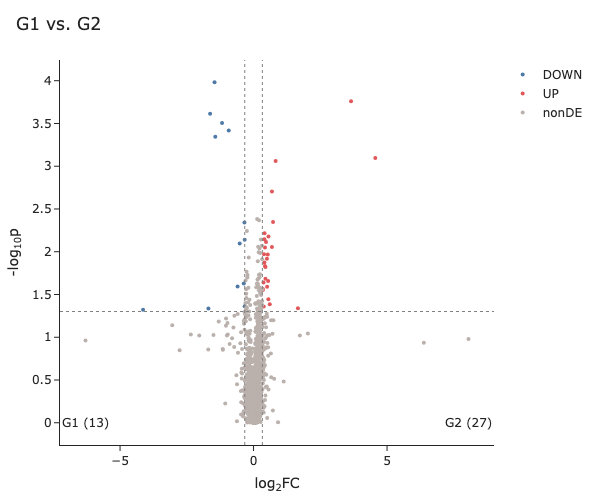

In [34]:
de_res.plot_volcano()

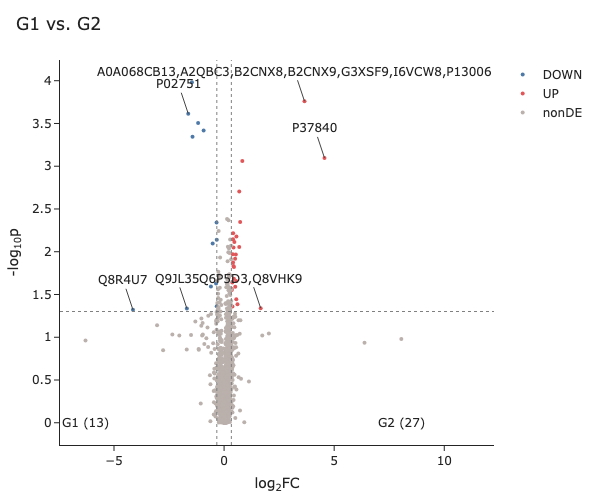

In [35]:
de_res.plot_volcano(label_top=3)